# Variational Autoencoder

![VAE](notebook_images/vae.jpg)


In [11]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle

import numpy as np
import time

import os
import pathlib
from PIL import Image
import skimage

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, '../../util')
import vcpi_util

In [12]:
print(torch.__version__)

2.2.1+cu118


# Aux functions for display purposes

In [13]:
from matplotlib import colors

def plot_scatter(x,y,targets):
    cmap = colors.ListedColormap(['black', 'darkred', 'darkblue', 
                                  'darkgreen', 'yellow', 'brown', 
                                  'purple', 'lightgreen', 'red', 'lightblue'])
    bounds=[0, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5,8.5,9.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(12,10))
    plt.scatter(x, y, c = targets, cmap=cmap, s = 1, norm=norm)
    plt.colorbar()

    plt.show()


def show_preds(set1, set2, count):
  
  columns = 4
  rows = int(count*2 / columns) + 1  
  plt.figure(figsize=(count, 2 * rows))
  
  for n in range(count):
      ax = plt.subplot(rows, columns, n*2+1)
      plt.title("original")
      plt.imshow(np.transpose(set1[n].numpy(), (1,2,0)), cmap=plt.cm.gray)
      plt.axis('off')
      ax = plt.subplot(rows, columns, n*2+2)
      plt.title("reconstruction")
      plt.imshow(np.transpose(set2[n].cpu().detach().numpy(), (1,2,0)), cmap=plt.cm.gray)
      plt.axis('off')      

## Configuration

In [14]:
HEIGHT = 28
WIDTH = 28
NUM_CHANNELS = 1
BATCH_SIZE = 32
LATENT_SPACE_DIM = 2

model_path = 'd:/vcpi/DL07/autoencoder_mnist'

train_online = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:0


### Load and prepare MNIST dataset

In [15]:
transform = transforms.Compose(
    [transforms.ToTensor()]) #, transforms.RandomHorizontalFlip(1.0)])

train_set = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True)

test_set = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False)

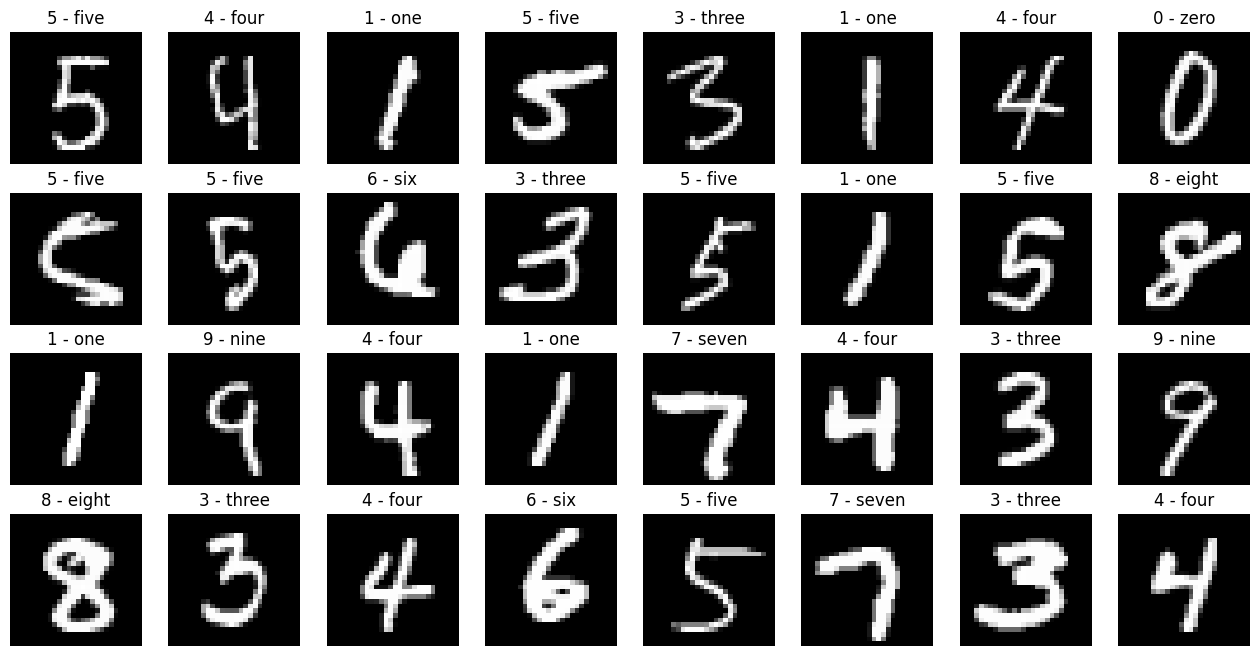

<Figure size 640x480 with 0 Axes>

In [16]:
images, targets = next(iter(train_loader))

vcpi_util.show_images(4,8, images, targets, train_set.classes) 

In [17]:
class Encoder(torch.nn.Module):
    def __init__(self, latent_space_dim):
        super().__init__()
        
        self.econv1 = torch.nn.Conv2d(in_channels=NUM_CHANNELS, out_channels=32, kernel_size=3, stride=2)
        self.erelu1 = torch.nn.ReLU()
        self.ebn1 = torch.nn.BatchNorm2d(32)
        
        self.econv1 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.erelu1 = torch.nn.ReLU()
        self.ebn1 = torch.nn.BatchNorm2d(64)
        
        self.efc1_mean = torch.nn.Linear(3136, latent_space_dim)
        self.efc1_log_var = torch.nn.Linear(3136, latent_space_dim)
        
    def forward(self, x):
        
        x = torch.nn.functional.pad(x,(0,1,0,1))
        x = self.econv1(x)
        x = self.ebn1(x)
        x = self.erelu1(x)
        
        x = torch.nn.functional.pad(x,(0,1,0,1))
        x = self.econv2(x)
        x = self.ebn2(x)
        x = self.erelu2(x)
        
        x = torch.flatten(x,1)
        
        mean = self.efc1_mean(x)
        log_var = self.efc1_log_var(x)
        
        return mean, log_var
        

In [18]:
class Decoder(torch.nn.Module):
    
    def __init__(self, latent_space_dim):
        
        super().__init__()
        
        self.dfc1 = torch.nn.Linear(latent_space_dim, 3136)
        
        self.dconvT1 = torch.nn.ConvTranspose2d(64, 32, 3, 2, padding=1, output_padding=1)
        self.drelu1 = torch.nn.ReLU()
        self.dbn1 = torch.nn.BatchNorm2d(32)
        
        self.dconvT2 = torch.nn.ConvTranspose2d(32, 1, 3, 2, padding=1, output_padding=1)
        self.dsig = torch.nn.Sigmoid()
        
    def forward(self, x):
        
        x = self.dfc1(x) # 10 -> 3136
        x = x.reshape(-1, 64, 7, 7) # 3136 -> (64,7,7)
        
        x = self.dconvT1(x)
        x = self.dbn1(x)
        x = self.drelu1(x)
        
        x = self.dconvT2(x)
        x = self.dsig(x)
        
        return x
        

In [19]:
class VAE(torch.nn.Module):
    
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        
    def reparametrization(self, mean, log_var):
        
        epsilon = torch.randn_like(mean).to(device)
        
        z = mean + log_var * epsilon
        
        return z
    
    def forward(self, x):
        
        mean, log_var = self.encoder(x)
        
        z = self.reparametrization(mean, log_var)
        
        x = self.decoder(z)
        
        return x, mean, log_var

In [ ]:
encoder = Encoder(LATENT_SPACE_DIM)
decoder = Decoder(LATENT_SPACE_DIM)

model = VAE(encoder, decoder).to(device)
torchinfo.summary(model, input_size=(BATCH_SIZE, NUM_CHANNELS, HEIGHT, WIDTH))

In [21]:
BCE_loss = torch.nn.BCELoss()

def loss_function(x, output, mean, log_var):
    
    reproduction_loss = BCE_loss(output, x)
    
    KL_loss = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    
    return reproduction_loss + KL_loss

optimizer = torch.optim.Adam(model.parameters())

In [ ]:
EPOCHS = 3

for epoch in range(EPOCHS):
    
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        
        x = x.to(device)
        
        optimizer.zero_grad()
        
        output, mean, log_var = model(x)
        
        loss = loss_function(x, output, mean, log_var)
        
        overall_loss += loss
        
        loss.backward()
        
        optimizer.step()
        
    print(f'Epoch {epoch+1}, Average Loss: {overall_loss / (batch_idx*BATCH_SIZE)}')
    
print('Finish')